In [533]:
import sys
import os
from pathlib import Path

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

GNDTRUTH = Path('../data/raw/COMMON_images_masks/')
RAWIMGS = Path('../data/raw/GROUP_images/')
DATA = (RAWIMGS.parent).parent

img_path = RAWIMGS/'g1_54_image.nii.gz'

In [45]:
from ipywidgets import interact, IntSlider, fixed
import matplotlib.pyplot as plt
import numpy as np

def show_coronal_slice(arr, slc, mask=None):
    plt.figure(figsize=(5,5))
    plt.imshow(arr[:, slc, :], cmap='gray')
    
    if mask is not None:
        plt.imshow(
            np.ma.masked_where(mask[:, slc, :] == 0, mask[:, slc, :]),
            cmap='hsv',
            alpha=0.4
        )
    
    plt.axis('off')
    plt.title(f'Slice {slc}')
    plt.show()

def show_interactive(arr, fn, mask=None):
    return interact(
        fn,
        slc=IntSlider(min=0, max=arr.shape[1]-1, step=1, value=arr.shape[1]//2),
        arr=fixed(arr),
        mask=fixed(mask)
    )

In [49]:
import matplotlib.pyplot as plt
img = sitk.ReadImage(img_path)
im_arr = sitk.GetArrayFromImage(img)
show_interactive(im_arr, show_coronal_slice)
im_arr.shape

interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

(276, 512, 512)

In [56]:
bones = np.clip(im_arr, a_min=150, a_max=1000)
show_interactive(bones, show_coronal_slice)

interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.show_coronal_slice(arr, slc, mask=None)>

In [88]:
bone_mask = sitk.Threshold(img, lower=150, upper=1500, outsideValue=0)
# bone_mask = sitk.Cast(bone_mask, sitk.sitkUInt8)
bone_mask = sitk.BinaryOpeningByReconstruction(bone_mask, [1,1,1])
bone_mask = sitk.BinaryMorphologicalClosing(bone_mask, kernelRadius=[8,8,8])
bone_mask = sitk.BinaryFillhole(bone_mask)

In [500]:
mask_arr = sitk.GetArrayFromImage(bone_mask)
show_interactive(mask_arr, show_coronal_slice)

interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.show_coronal_slice(arr, slc, mask=None)>

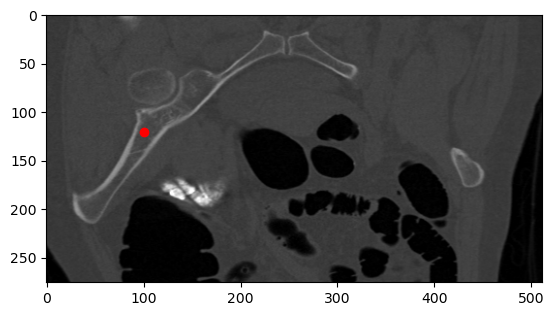

In [105]:
point = (100,120)
plt.imshow(im_arr[:,265,:], cmap='gray')
plt.plot(point[0], point[1],'ro')
plt.show()

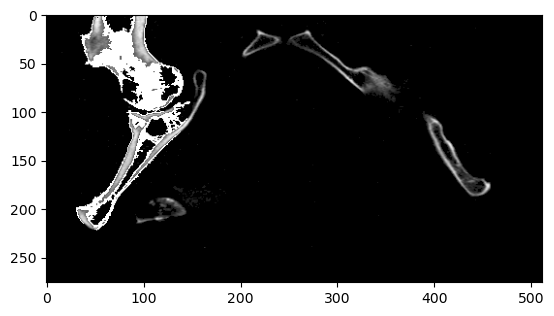

In [185]:
msk_fill = ski.segmentation.flood_fill(mask_arr[:,278,:], (point[1],point[0]), 1500, tolerance=250)
plt.imshow(msk_fill, cmap='gray')

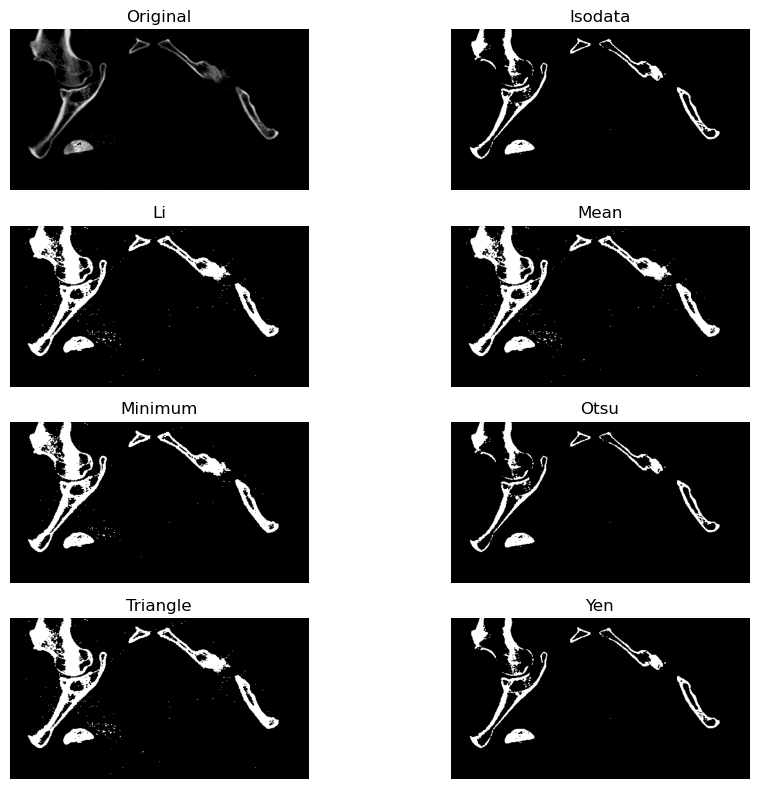

In [501]:
from skimage.filters import threshold_yen
fig, ax = try_all_threshold(mask_arr[:,280,:], figsize=(10, 8), verbose=False)
plt.show()

In [524]:
import skimage as ski

mask8 = mask_arr.astype(np.uint8)
lst = []

for slice in mask_arr:
    thrsh = ski.filters.threshold_yen(slice)
    slc_thr = slice >thrsh
    lst.append(slc_thr)
im_thrsh = np.array(lst)
im_thrsh = im_thrsh.astype(np.uint8)

show_interactive(im_thrsh,show_coronal_slice)


interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.show_coronal_slice(arr, slc, mask=None)>

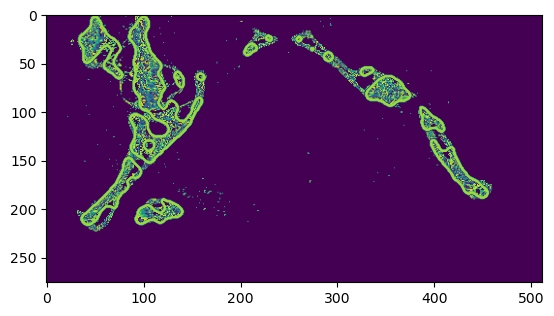

In [522]:
im_tst = mask_arr[:,281,:].astype(np.uint8)
# footprint = sk.morphology.disk(1)
# res = sk.morphology.white_tophat(im_tst, footprint)

init_ls = ski.segmentation.checkerboard_level_set(res.shape, 14)
seg = ski.segmentation.morphological_chan_vese(im_tst, num_iter=6, init_level_set=init_ls, smoothing=4, lambda1=0.56, lambda2=0.6)
skimage multiple active contours
plt.imshow(im_tst)
plt.contour(seg)
plt.show()

In [537]:
im_bones = sitk.GetImageFromArray(im_thrsh)
im_bones.SetSpacing(img.GetSpacing())
im_bones.SetOrigin(img.GetOrigin())
im_bones.SetDirection(img.GetDirection())
sitk.WriteImage(im_bones, DATA/'g1_54_thrsh.nii.gz')

In [543]:
import scipy.ndimage as ndi

closed = ndi.binary_closing(im_thrsh, structure=np.ones([1,1,1]))
show_interactive(closed, show_coronal_slice)

interactive(children=(IntSlider(value=256, description='slc', max=511), Output()), _dom_classes=('widget-inter…

<function __main__.show_coronal_slice(arr, slc, mask=None)>